## CV10 - CAM을 만들고 평가해보자
### CAM 구현하기

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *

import numpy as np
import os
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'cars196',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

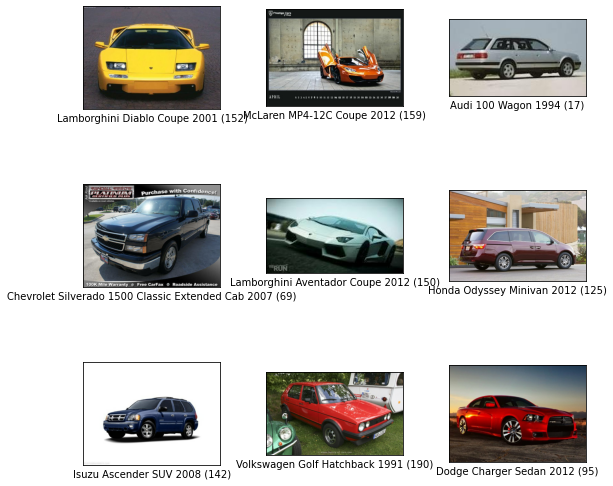

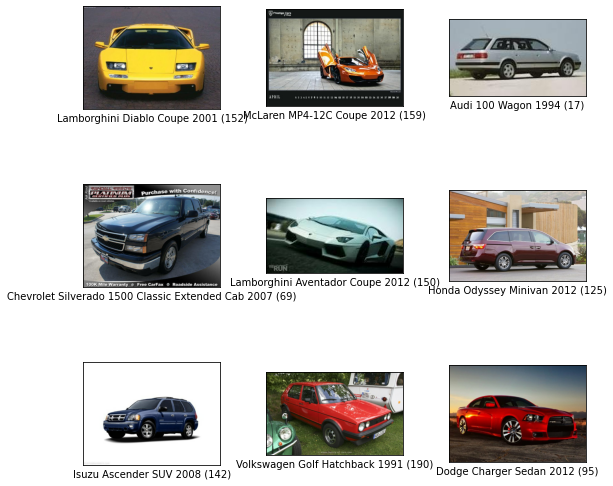

In [4]:
tfds.show_examples(ds_train, ds_info)

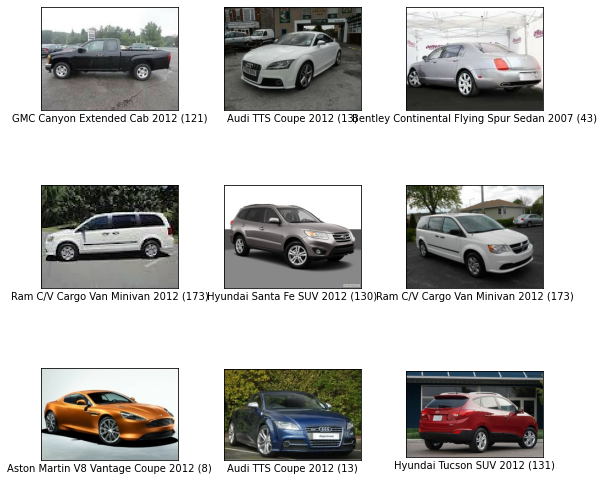

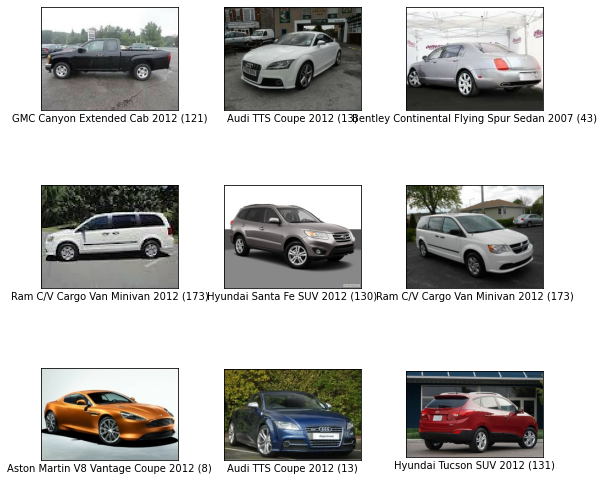

In [5]:
tfds.show_examples(ds_test, ds_info)

In [6]:
ds_info.features

FeaturesDict({
    'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=196),
})

In [7]:
num_classes = ds_info.features['label'].num_classes

base_model = keras.applications.resnet.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3),
    pooling='avg')

x = base_model.output
preds = Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

In [8]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [9]:
def normalize_and_resize_img(input):
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(normalize_and_resize_img, num_parallel_calls=2)
    ds = ds.batch(batch_size)
    
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [10]:
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

In [11]:
tf.random.set_seed(2020)
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy']
)

In [12]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
509/509 [==============================] - 84s 166ms/step - loss: 4.1292 - accuracy: 0.1707 - val_loss: 5.4097 - val_accuracy: 0.0153
Epoch 2/15
509/509 [==============================] - 84s 166ms/step - loss: 1.6150 - accuracy: 0.6540 - val_loss: 1.8622 - val_accuracy: 0.5238
Epoch 3/15
509/509 [==============================] - 113s 222ms/step - loss: 0.5533 - accuracy: 0.9023 - val_loss: 1.2421 - val_accuracy: 0.6770
Epoch 4/15
509/509 [==============================] - 82s 162ms/step - loss: 0.1828 - accuracy: 0.9813 - val_loss: 1.0596 - val_accuracy: 0.7215
Epoch 5/15
509/509 [==============================] - 83s 162ms/step - loss: 0.0599 - accuracy: 0.9969 - val_loss: 1.0106 - val_accuracy: 0.7316
Epoch 6/15
509/509 [==============================] - 82s 162ms/step - loss: 0.0372 - accuracy: 0.9979 - val_loss: 0.9870 - val_accuracy: 0.7404
Epoch 7/15
509/509 [==============================] - 81s 160ms/step - loss: 0.0270 - accuracy: 0.9979 - val_loss: 0.9689 - val_a

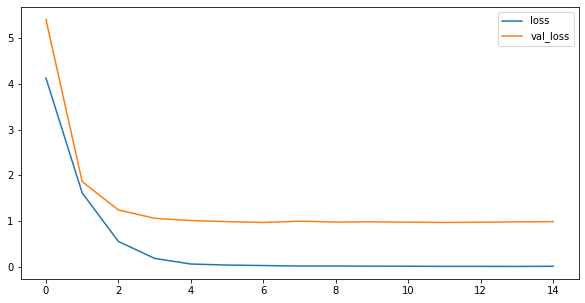

In [16]:
plt.figure(figsize=(10,5))
plt.plot(history_cam_model.history['loss'], label='loss')
plt.plot(history_cam_model.history['val_loss'], label='val_loss')
plt.legend()
plt.show()


In [12]:
cam_model_path = os.getenv('HOME') + '/aiffel/class_activation_map/cam_model.h5'
cam_model.save(cam_model_path)

In [13]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

189


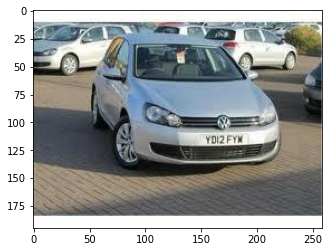

In [14]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [15]:
cam_model = tf.keras.models.load_model(cam_model_path)

In [16]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # GAP 적용되기 전의 레이어를 가져온다. 특성맵 구하기
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0]
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    # 클래스별 확률을 얻기 위한 소프트맥스 레이어의 가중치
    for i, w in enumerate(class_weights[:, class_idx]):
        cam_image += w * conv_outputs[:, :, i]
        
    cam_image /= np.max(cam_image)
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height))
    return cam_image

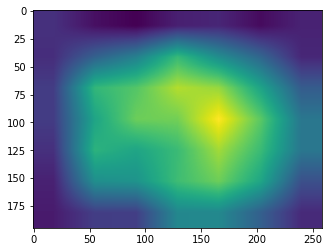

In [17]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [24]:
def visualize_cam_on_image(image, cam_image):
    merged_image = cv2.addWeighted(cam_image, 0.2, image, 0.8, 0.0)
    return merged_image

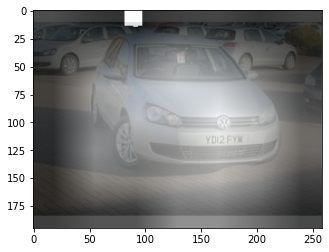

In [25]:
origin_image = item['image'].astype(np.uint8)
cam_image_3ch = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3ch, origin_image)
plt.imshow(blended_image)
plt.show()

### Grad-CAM

12


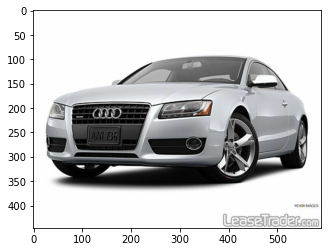

In [26]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [32]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] 
        output = conv_output[0] 
        grad_val = tape.gradient(loss, conv_output)[0] 

    weights = np.mean(grad_val, axis=(0, 1)) 
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    # 클래스별 가중치
    for k, w in enumerate(weights):
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

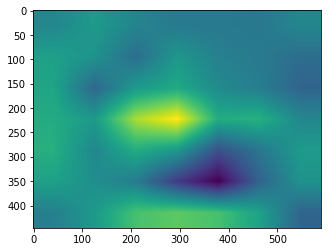

In [33]:
grad_cam_image5 = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image5)
plt.show()

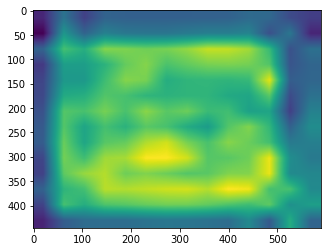

In [34]:
grad_cam_image4 = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image4)
plt.show()

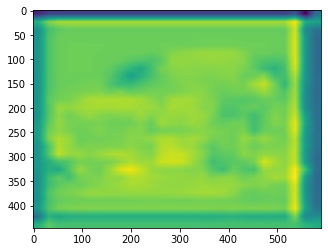

In [35]:
grad_cam_image3 = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image3)
plt.show()

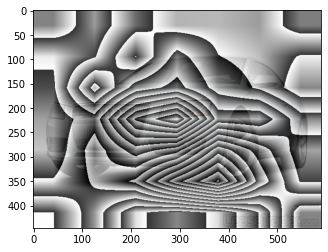

In [36]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image5_3ch = np.stack([grad_cam_image5*255]*3, axis=-1).astype(np.uint8)

blended_image5 = visualize_cam_on_image(grad_cam_image5_3ch, origin_image)
plt.imshow(blended_image5)
plt.show()

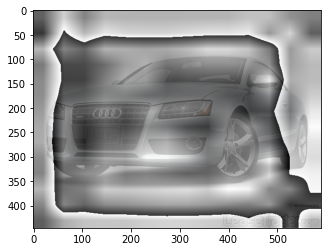

In [37]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image4_3ch = np.stack([grad_cam_image4*255]*3, axis=-1).astype(np.uint8)

blended_image4 = visualize_cam_on_image(grad_cam_image4_3ch, origin_image)
plt.imshow(blended_image4)
plt.show()

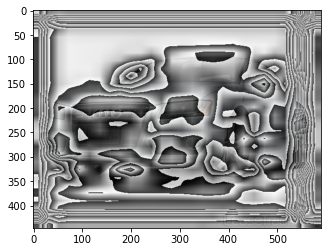

In [38]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image3_3ch = np.stack([grad_cam_image3*255]*3, axis=-1).astype(np.uint8)

blended_image3 = visualize_cam_on_image(grad_cam_image3_3ch, origin_image)
plt.imshow(blended_image3)
plt.show()

### 바운딩 박스 구하기

121


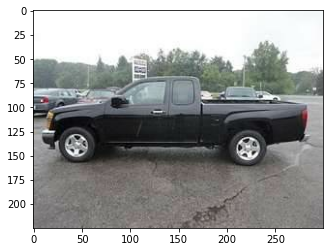

In [39]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

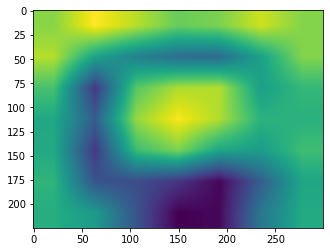

In [42]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

In [43]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [44]:
image = copy.deepcopy(item['image'])
rect = get_bbox(grad_cam_image)
rect

array([[152, 128],
       [136, 112],
       [152,  96],
       [168, 112]])

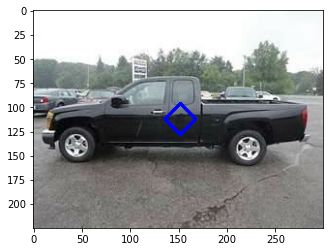

In [45]:
image = cv2.drawContours(image,[rect],0,(0,0,255),2)
plt.imshow(image)